In [1]:
#Claire Roush
#CS 167 - Prof Manley
#December 12, 2016
#Airline Tweets text data classification with SVM, PCA, Naive Bayes, and Random Forests.

import pandas
from bs4 import BeautifulSoup
import re
import nltk
import numpy
#nltk.download()
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection as cv
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import preprocessing

#stopSet = set(stopwords.words("english"))
cleaned_data = []
print("starting read_csv")
data=pandas.read_csv("Tweets.csv", usecols=[1,2,10])
print("done with read_csv, starting labelencoder")

le_sentiment = preprocessing.LabelEncoder()

#to convert into numbers
# source: https://www.kaggle.com/c/titanic/forums/t/5379/handling-categorical-data-with-sklearn?forumMessageId=139270

data.airline_sentiment = le_sentiment.fit_transform(data.airline_sentiment)
print("done with label encoder")

#df_sentiment = pandas.get_dummies(data["airline_sentiment"])
#data = pandas.concat([data, df_sentiment], axis=1)
#data = data.drop("airline_sentiment",1)
#columns to use for sentiment are now 'neutral', 'positive' and 'negative

#print(data["text"][0])
#cited source: https://pythonprogramming.net/stop-words-nltk-tutorial/
stopSet = set(stopwords.words("english"))

def clean_it(wordData):
    minus_punctuation = re.sub("[^a-zA-Z]"," ",wordData)
    to_lowercase = minus_punctuation.lower()
    tokenized = to_lowercase.split()
    #filtered = [i for i in tokenized if not i in stopSet]
    return tokenized

print("starting loop")
i = 0
while (i<len(data)):
    temp = clean_it(data["text"][i])
    temp = ' '.join(temp)
    cleaned_data.append(temp)
    #print(temp)
    i=i+1
print("done with loop, starting vectorizer")
#print(cleaned_data[0])


vectorizer = CountVectorizer(analyzer='word')
word_columns = vectorizer.fit_transform(cleaned_data)
#print(word_columns)
#convert to numpy array so we can feed it #into learning algorithm
word_columns = word_columns.toarray()
print("done with vectorizer")
#print(vectorizer.get_feature_names())

(train_data, test_data, train_target, test_target) = cv.train_test_split(word_columns, data["airline_sentiment"], test_size = 0.2)

print("done")

starting read_csv
done with read_csv, starting labelencoder
done with label encoder
starting loop
done with loop, starting vectorizer
done with vectorizer
done


In [99]:
data.iloc[0]

airline_sentiment                                                 1
airline_sentiment_confidence                                      1
text                            @VirginAmerica What @dhepburn said.
Name: 0, dtype: object

In [106]:
mnb = MultinomialNB()
mnb.fit(train_data,train_target)
preds = mnb.predict(test_data)
print(accuracy_score(preds,test_target))
print("done")

0.746926229508
done


In [107]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(train_data,train_target)
preds_2 = gnb.predict(test_data)
print(accuracy_score(preds_2,test_target))
print("done")


0.501024590164
done


In [ ]:
from sklearn.decomposition import PCA #new one!
pca = PCA(n_components=400,whiten=True)
pca.fit(train_data)
transformed_train_data = pca.transform(train_data) 
transformed_test_data = pca.transform(test_data)
print("done")

done


In [97]:
from sklearn import grid_search
params = {'alpha': (0,0.5,1,2,4),
          'fit_prior': (True, False),
         }
mnb = grid_search.GridSearchCV(MultinomialNB(),params)
mnb.fit(train_data,train_target)
preds_6 = mnb.predict(test_data)
print(accuracy_score(preds_6,test_target))
mnb.best_params_

0.77356557377


{'alpha': 0.5, 'fit_prior': False}

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, criterion='entropy', max_features='log2')
rf.fit(train_data,train_target)
rf_predictions = rf.predict(test_data)
print(accuracy_score(rf_predictions,test_target))
print("done")

0.758879781421
done


In [ ]:
svc = SVC(gamma=0.1)
svc.fit(train_data,train_target)
preds_3 = svc.predict(test_data)
print(accuracy_score(preds_3,test_target))
print("done")



In [ ]:
svc = SVC(gamma=0.1)
svc.fit(transformed_train_data,train_target)
preds_3 = svc.predict(transformed_test_data)
print(accuracy_score(preds_3,test_target))
print("done")




In [ ]:
from sklearn import grid_search
params = {'C': (0.1,1,2,3),
          'kernel': ('linear','poly','rbf'),
          'degree': (0,1,2,3),
          'gamma': (0.1,1),
          'coef0': (0.1,1,2)
         }
svc = grid_search.GridSearchCV(SVC(),params)
svc.fit(transformed_train_data,train_target)
preds_6 = svc.predict(transformed_test_data)
print(accuracy_score(preds_6,test_target))
svc.best_params_

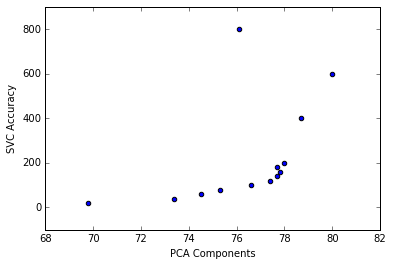

In [86]:

import matplotlib.pyplot as plt
%matplotlib inline

pca = [20,  40,  60,  80,  100, 120, 140, 160,  180,  200,  400, 600, 800]
svc = [69.8,73.4,74.5,75.3,76.6,77.4,77.7,77.8, 77.7, 78.0, 78.7, 80,  76.1]

plt.ylabel('SVC Accuracy')
plt.xlabel('PCA Components')
plt.scatter(svc,pca)



## Text Analysis of Twitter Airline Data ##

#### The Data ####

I retrieved the dataset from: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

The dataset is comprised of 14,641 tweets regarding airlines Virgin America, United, Southwest, Delta, US Airways, and American. The task cited by the Kaggle page is to determine sentiment and to group sentiments to each airline. The end results would be a complete picture of negative, neutral, and positive sentiments on Twitter for each given airline. I'm going to simplify the task a bit to only predict sentiment. 

#### Clean Up ####

The first thing I did while examining the data in Excel was to decide which columns I wanted to use. I decided on ```airline_sentiment```, ```airline_sentiment_confidence```, and ```text```, which are the sentiment classification, a confidence rating (weight), and the tweet body, respectively. I read in only these columns using ```usecols```. The other columns were ignored because their data didn't seem important to this project. I intended to use the weights (confidence rating), but this proved to be a bit more difficult than I originally thought. 


For classification algorithm purposes, I needed to convert the ```positive, neutral, negative``` classifications in the ```airline_sentiment``` column to integers. I did this with ```LabelEncoder```. I was then left with data that looked like:

<img src="data.png" width=50%, height=50%>

I then removed punctuation, converted to lowercase and tokenized in my ```clean_it``` function, which was called by a loop and performed on each tweet before joining back into a string and appended to ```cleaned_data```.

I used ```CountVectorizer``` to convert my appended strings in ```cleaned_data``` to a word count vector. I then converted to a numpy array and split into a training and testing set. It is now ready to test with different algorithms.. 

#### Naive Bayes ####

The first Naive Bayes algorithm I used was Multinomial Naive Bayes. The accuracy straight "out of the box" for this was ```0.7634```. The second Naive Bayes algorithm I used was Gaussian Naive Bayes. The accuracy score straight out of the box for GNB was ```0.492```. I decided to do further testing with Multinomial Naive Bayes. 

At first I chose not to perform a Grid Search with Naive Bayes algorithms, as the algorithms are simple enough to test parameters manually. Later, though, I did use Grid Search to find the best ```alpha``` value of 0.5, as well as a ```prior_search``` of ```False```. The accuracy of MNB with ```alpha=0.5,prior_search=False``` was 77.4. The accuracy was a bit better, but still not as good as I expected. I felt that I had run out of options with MNB. With the removal of stopwords, the accuracy of Multinomial Naive Bayes fell an average of ```0.02```. 

I tried Gaussian Naive Bayes next with transformed data from Principal Component Analysis. With ```n_components``` from 50-800, Gaussian Naive Bayes performed at ```0.618``` accuracy at its best, with ```n_components=50```. With the removal of stopwords, Gaussian Naive Bayes accuracy dropped an overage of ```0.03```. 

#### Principal Component Analysis and Support Vector Machines ####

I ran a series of tests to determine the best number of components for PCA according to SVC.

<img src="PCASVC.png" width=50%, height=50%>

I found that right around ```n_components=600``` was a good area for SVC accuracy. 

Next, I ran a grid search for Support Vector Machines with the following parameters:

```params = {'C': (0.000000001,0.000001,0.00001,0.001,0.1,0,1,2,3),
          'kernel': ('linear','poly','rbf','sigmoid','precomputed'),
          'degree': (0,1,2,3,4,5,6),
          'gamma': (0.00001,0.0001,0.001,0.1,1,10),
          'coef0': (0.0001,0.001,0.1,1,2,3,4),
          'shrinking': (True,False),
          'tol': (0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.1,1)
         }
```

This grid search ran over 12 hours and still wasn't complete. As a result, I interrupted the kernel, manually tested different parameters and found ```gamma=0.1, C=1, kernel='rbf',degree=4,coef0=0.0``` to produce the best average accuracy of ```0.823```. 


#### Random Forest ####

Out of curiosity, and after reading <b><a href="https://pdfs.semanticscholar.org/9b2f/84d85e5b6979bf375a2d4b15f7526597fc70.pdf">An Improved Random Forest Classifier for Text Categorization</a></b>, I thought I'd try Random Forest on this dataset. The paper proposes to improve Random Forest algorithm by enhancing the performance of individual trees by "a feature weighted method proposed by Amaratunga" (1), and by watching for "bad" trees and cutting them out before their input distorts the ultimate prediction. This was pretty interesting to me, and made me curious as to the performance of the ScikitLearn Random Forest Classifier without the optimizations proposed in the paper.

The following table shows the accuracy change dependent upon ```n_estimators```. 


| n_estimators| Accuracy   
| ------------|:-----------:|
| 10          | 0.752       |
| 100         | 0.765       |
| 200         | 0.783       |
| 300         | 0.763       |

I tried to recreate the optimizations proposed in the paper, but wasn't entirely sure how to do so. With 
*max_features='log2',min_samples_split=4,criterion='entropy',n_estimators=200*, a "bad" tree is perhaps less likely, though I wasn't positive how to implement the feature weighted optimization. The accuracy of this algorithm with these paramaters was ```0.76```. 

#### Analyzation ####


Over all, Support Vector Machines performed best with the transformed data from Principal Component Analysis. I'm not sure why this is the case. Processing the data into word count vectors, then projecting them to a higher dimension with PCA may have made the data separable by SVM. Perhaps a decent linear separation exists in this case.

Naive Bayes' performance surprised me. It makes sense to me that Multinomial Naive Bayes performed what it did, when word freqency would be used in maximum likelihood estimation. Word frequency is probably a really important part of this data, so it follows that Multinomial Naive Bayes outperformed Gaussian. However, I still expected the Naive Bayes algorithms to perform better than they did.

The removal of stopwords, overall, seemed to hurt performance in all algorithms. This was interesting.

Random Forest Classifier's performance was about where I expected. The article linked above proposed interesting optimizations which I tried to recreate, partially, though parameters. However, this produced accuracy scores less than impressive. Of course, the paper's optimization proposals are more than the scope of this project. 
